# LKJ Cholesky Covariance Priors for Multivariate Normal Models

While the [inverse-Wishart distribution](https://en.wikipedia.org/wiki/Inverse-Wishart_distribution) is the conjugate prior for the covariance matrix of a multivariate normal distribution, it is [not very well-suited](https://github.com/pymc-devs/pymc3/issues/538#issuecomment-94153586) to modern Bayesian computational methods.  For this reason, the [LKJ prior](http://www.sciencedirect.com/science/article/pii/S0047259X09000876) is recommended when modeling the covariance matrix of a multivariate normal distribution.

To illustrate modelling covariance with the LKJ distribution, we first generate a two-dimensional normally-distributed sample data set.

In [1]:
import arviz as az
import numpy as np
import pymc3 as pm
import seaborn as sns
import warnings

from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt

In [2]:
az.style.use("arviz-darkgrid")
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8924
np.random.seed(3264602)  # from random.org

In [3]:
N = 10000

μ_actual = np.array([1, -2])
Σ_actual = np.array([[0.5, -0.3], [-0.3, 1.0]])

x = np.random.multivariate_normal(μ_actual, Σ_actual, size=N)

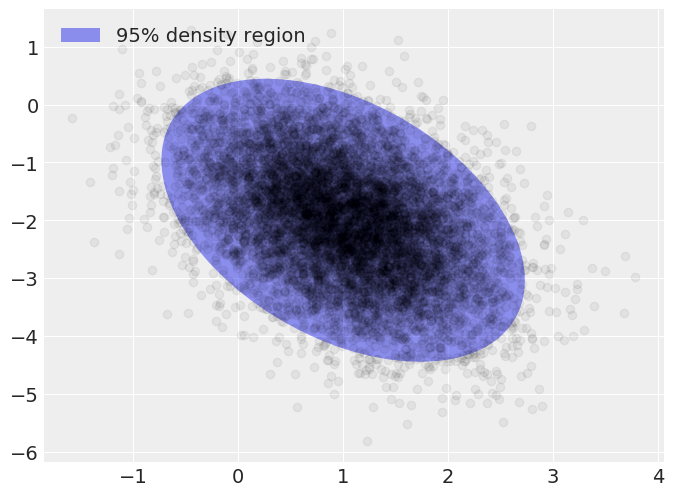

In [5]:
var, U = np.linalg.eig(Σ_actual)
angle = 180.0 / np.pi * np.arccos(np.abs(U[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red, *_ = sns.color_palette()

e = Ellipse(
    μ_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle
)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10)
ax.add_artist(e)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect], ["95% density region"], loc=2);

The sampling distribution for the multivariate normal model is $\mathbf{x} \sim N(\mu, \Sigma)$, where $\Sigma$ is the covariance matrix of the sampling distribution, with $\Sigma_{ij} = \textrm{Cov}(x_i, x_j)$. The density of this distribution is

$$f(\mathbf{x}\ |\ \mu, \Sigma^{-1}) = (2 \pi)^{-\frac{k}{2}} |\Sigma|^{-\frac{1}{2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mu)^{\top} \Sigma^{-1} (\mathbf{x} - \mu)\right).$$

The LKJ distribution provides a prior on the correlation matrix, $\mathbf{C} = \textrm{Corr}(x_i, x_j)$, which, combined with priors on the standard deviations of each component, [induces](http://www3.stat.sinica.edu.tw/statistica/oldpdf/A10n416.pdf) a prior on the covariance matrix, $\Sigma$. Since inverting $\Sigma$ is numerically unstable and inefficient, it is computationally advantageous to use the [Cholesky decompositon](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\Sigma$, $\Sigma = \mathbf{L} \mathbf{L}^{\top}$, where $\mathbf{L}$ is a lower-triangular matrix. This decompositon allows computation of the term $(\mathbf{x} - \mu)^{\top} \Sigma^{-1} (\mathbf{x} - \mu)$ using back-substitution, which is more numerically stable and efficient than direct matrix inversion.

PyMC3 supports LKJ priors for the Cholesky decomposition of the covariance matrix via the [LKJCholeskyCov](../api/distributions/multivariate.rst) distribution. This distribution has parameters `n` and `sd_dist`, which are the dimension of the observations, $\mathbf{x}$, and the PyMC3 distribution of the component standard deviations, respectively. It also has a hyperparamter `eta`, which controls the amount of correlation between components of $\mathbf{x}$. The LKJ distribution has the density $f(\mathbf{C}\ |\ \eta) \propto |\mathbf{C}|^{\eta - 1}$, so $\eta = 1$ leads to a uniform distribution on correlation matrices, while the magnitude of correlations between components decreases as $\eta \to \infty$.

In this example, we model the standard deviations with $\textrm{Exponential}(1.0)$ priors, and the correlation matrix as $\mathbf{C} \sim \textrm{LKJ}(\eta = 2)$.

In [6]:
with pm.Model() as m:
    packed_L = pm.LKJCholeskyCov(
        "packed_L", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0)
    )

Since the Cholesky decompositon of $\Sigma$ is lower triangular, `LKJCholeskyCov` only stores the diagonal and sub-diagonal entries, for efficiency:

In [7]:
packed_L.tag.test_value.shape

(3,)

We use [expand_packed_triangular](../api/math.rst) to transform this vector into the lower triangular matrix $\mathbf{L}$, which appears in the Cholesky decomposition $\Sigma = \mathbf{L} \mathbf{L}^{\top}$.

In [9]:
with m:
    L = pm.expand_packed_triangular(2, packed_L)
    Σ = L.dot(L.T)

L.tag.test_value.shape

(2, 2)

Often however, you'll be interested in the posterior distribution of the correlations matrix and of the standard deviations, not in the posterior Cholesky covariance matrix *per se*. Why? Because the correlations and standard deviations are easier to interpret and often have a scientific meaning in the model. As of PyMC 3.9, there is a way to tell PyMC to automatically do these computations and store the posteriors in the trace. You just have to specify `compute_corr=True` in `pm.LKJCholeskyCov`:

In [10]:
with pm.Model() as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))

To complete our model, we place independent, weakly regularizing priors, $N(0, 1.5),$ on $\mu$:

In [11]:
with model:
    μ = pm.Normal("μ", 0.0, 1.5, shape=2, testval=x.mean(axis=0))
    obs = pm.MvNormal("obs", μ, chol=chol, observed=x)

We sample from this model using NUTS and give the trace to [ArviZ](https://arviz-devs.github.io/arviz/):

In [12]:
with model:
    trace = pm.sample(random_seed=RANDOM_SEED, init="adapt_diag")
idata = az.from_pymc3(trace)
az.summary(idata, var_names=["μ", "chol_stds", "chol_corr"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],1.02,0.01,1.01,1.03,0.0,0.0,4344.76,4344.76,4319.22,3555.08,1.0
μ[1],-2.02,0.01,-2.04,-2.00,0.0,0.0,4182.52,4182.52,4186.98,3417.61,1.0
chol_stds[0],0.70,0.01,0.69,0.71,0.0,0.0,5133.98,5133.98,5153.06,3010.56,1.0
chol_stds[1],1.00,0.01,0.99,1.01,0.0,0.0,5341.08,5339.97,5340.78,3541.18,1.0
"chol_corr[0,0]",1.00,0.00,1.00,1.00,0.0,0.0,4000.00,4000.00,4000.00,4000.00,NaN
"chol_corr[0,1]",-0.42,0.01,-0.44,-0.41,0.0,0.0,4827.27,4827.27,4846.73,3328.37,1.0
"chol_corr[1,0]",-0.42,0.01,-0.44,-0.41,0.0,0.0,4827.27,4827.27,4846.73,3328.37,1.0
"chol_corr[1,1]",1.00,0.00,1.00,1.00,0.0,0.0,4000.00,4000.00,3441.47,3794.87,1.0


Both the traces and Gelman-Rubin statistics indicate excellent convergence. + interpretation

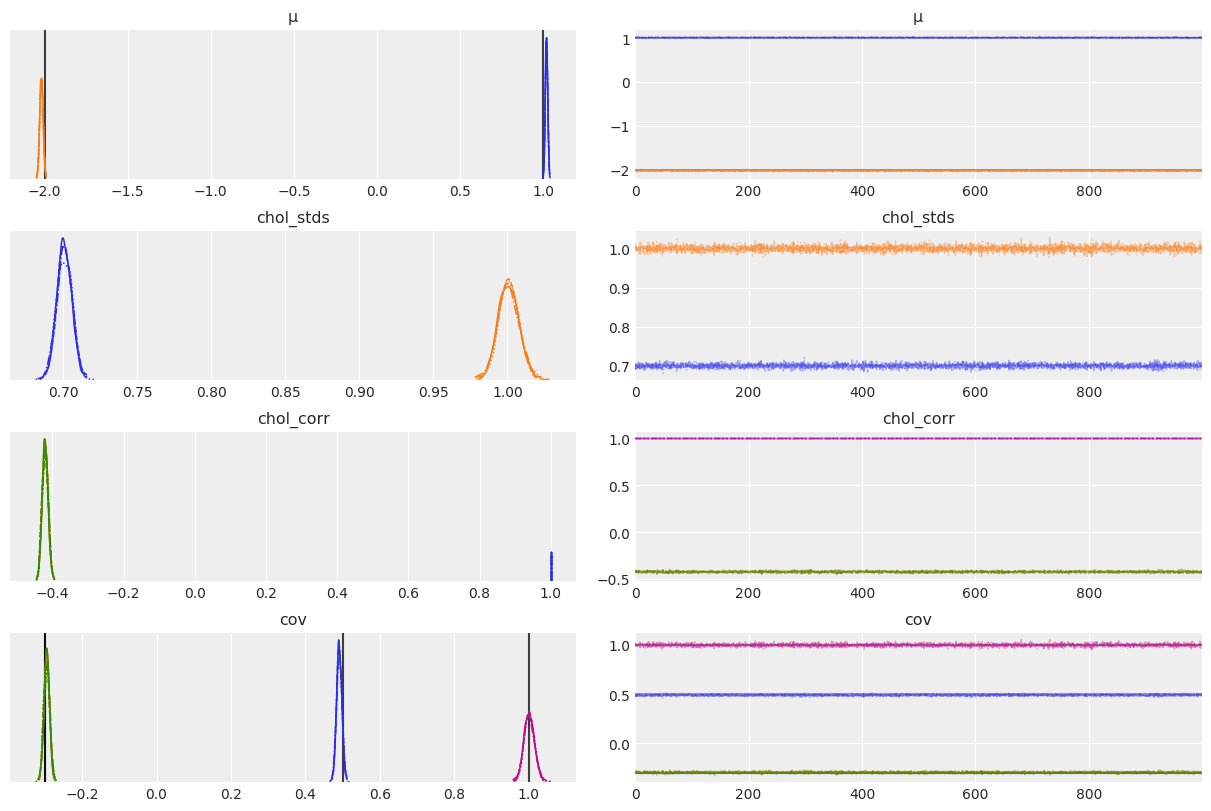

In [13]:
az.plot_trace(
    idata,
    var_names=["~chol"],
    compact=True,
    lines=[("μ", {}, μ_actual), ("cov", {}, Σ_actual)],
);

We see that the posterior expected value of the each component of $\mu$ and $\Sigma$ is within 2% of the true value.

In [14]:
μ_post = trace["μ"].mean(axis=0)
(1 - μ_post / μ_actual).round(2)

array([-0.02, -0.01])

In [15]:
Σ_post = trace["cov"].mean(axis=0)
(1 - Σ_post / Σ_actual).round(2)

array([[ 0.02,  0.02],
       [ 0.02, -0.  ]])

The following plot also shows excellent visual agreement between the true distribution and the posterior distribution.

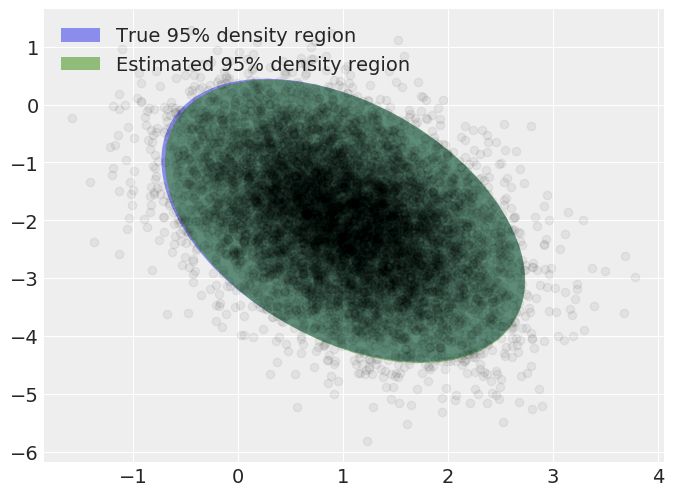

In [17]:
var_post, U_post = np.linalg.eig(Σ_post)
angle_post = 180.0 / np.pi * np.arccos(np.abs(U_post[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(
    μ_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle
)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10)
ax.add_artist(e)

e_post = Ellipse(
    μ_post,
    2 * np.sqrt(5.991 * var_post[0]),
    2 * np.sqrt(5.991 * var_post[1]),
    angle=angle_post,
)
e_post.set_alpha(0.5)
e_post.set_facecolor(red)
e_post.set_zorder(10)
ax.add_artist(e_post)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
rect_post = plt.Rectangle((0, 0), 1, 1, fc=red, alpha=0.5)
ax.legend(
    [rect, rect_post],
    ["True 95% density region", "Estimated 95% density region"],
    loc=2,
);

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3   3.8
seaborn 0.9.0
arviz   0.7.0
numpy   1.17.5
last updated: Tue Apr 21 2020 

CPython 3.8.0
IPython 7.11.0
watermark 2.0.2
